### 🧠 mpnet‑medical (Notebook Demo)

**Goal**: Fine‑tune a light‑weight encoder (**MiniLM/mpnet**) for the medical domain and *visually* compare **Base vs Fine‑tuned** (and optionally **+Triplet**) on small demo datasets.

**What you get in this notebook**
- Tiny demo datasets (three formats): `(sent1, sent2, score)`, `(query, pos)`, `(q, pos, neg)`
- Two‑phase fine‑tuning: **Cosine** (sentence similarity) → **MNR** (QA retrieval)
- Evaluation: **Spearman** (pairs), **Recall@5 / nDCG@10** (retrieval)
- Plots: **before/after** bar charts + **PCA 2D** embedding visualization
- Optional **Triplet** phase to strengthen discrimination

> Works well on inference.ai GPU notebooks. Ensure the environment can download models from Hugging Face.


In [1]:
# ======================================================
# ✅ Install all required dependencies at once
# ======================================================
!pip install -U -q sentence-transformers datasets matplotlib scikit-learn "accelerate>=0.26.0"

try:
    import ipywidgets
except ImportError:
    print("Installing ipywidgets to enable notebook progress bars...")
    !pip install -q ipywidgets tqdm
    import ipywidgets

 
import os, json, math, random, gc
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer, InputExample, losses

 
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))
else:
    print("⚠️CUDA not available, using CPU for training.")

 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm.auto")
print("✅Environment initialization complete — ready for model fine-tuning.")

PyTorch version: 2.4.0a0+07cecf4168.nv24.05
CUDA available: True
CUDA device: inference-ai GPU cuda
✅Environment initialization complete — ready for model fine-tuning.


In [2]:
# Reproducibility & paths
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DATA_DIR = "./data_demo"
OUT_DIR  = "./outputs_demo"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)

DATA_DIR: ./data_demo
OUT_DIR: ./outputs_demo


In [3]:
# Create tiny datasets (+augmentation)
pairs = [
    ("Patient has high blood pressure.", "The patient suffers from hypertension.", 0.95),
    ("The child presents with fever.", "The child has a high temperature.", 0.90),
    ("Shortness of breath on exertion.", "Dyspnea on exertion is reported.", 0.92),
    ("Blood glucose is elevated.", "The patient shows hyperglycemia.", 0.93),
    ("He denies chest pain.", "No chest pain is reported.", 0.88),
    ("ECG shows ST elevation.", "Electrocardiogram indicates ST-segment elevation.", 0.94),
    ("The patient has diabetes.", "The patient is on insulin therapy.", 0.60),
    ("She reports nausea and vomiting.", "The patient complains of abdominal discomfort.", 0.55),
    ("The wound is infected.", "The patient has a fever.", 0.50),
    ("Blood pressure improved after medication.", "Hypertension is controlled.", 0.62),
    ("Patient has high blood pressure.", "The ankle is sprained.", 0.10),
    ("He denies chest pain.", "He enjoys outdoor running.", 0.15),
    ("The MRI of the brain is normal.", "The patient bought new glasses.", 0.05),
    ("Glucose tolerance test was abnormal.", "The patient moved to another city.", 0.05),
    ("The patient is allergic to penicillin.", "The apartment is newly painted.", 0.00),
    ("The patient has elevated blood pressure.", "Hypertension is present in the patient.", 0.95),
    ("Child with fever for two days.", "The child has an elevated temperature.", 0.88),
    ("Reports dyspnea on exertion.", "The patient experiences shortness of breath when active.", 0.90),
]
pairs_path = os.path.join(DATA_DIR, "sentence_pairs.jsonl")
with open(pairs_path, "w") as f:
    for s1, s2, score in pairs:
        f.write(json.dumps({"sentence1": s1, "sentence2": s2, "score": float(score)}) + "\n")

qa_items = [
    ("What are common symptoms of diabetes?",
     "Common symptoms of diabetes include polyuria, polydipsia, and weight loss."),
    ("How to manage asthma exacerbation?",
     "Acute asthma exacerbation is managed with short-acting bronchodilators and systemic corticosteroids."),
    ("What is the first-line treatment for hypertension?",
     "First-line therapy for hypertension includes thiazide diuretics, ACE inhibitors, ARBs, or calcium channel blockers."),
    ("What are signs of myocardial infarction?",
     "Myocardial infarction typically presents with chest pain, diaphoresis, and shortness of breath."),
    ("Which lab test is used to monitor warfarin therapy?",
     "The INR (international normalized ratio) is used to monitor warfarin therapy."),
    ("What vaccine is recommended annually to reduce influenza risk?",
     "The seasonal influenza vaccine is recommended annually."),
    ("How is bacterial pneumonia treated?",
     "Bacterial pneumonia is treated with appropriate antibiotics based on likely pathogens and local resistance."),
    ("What is the management for DKA?",
     "Diabetic ketoacidosis is managed with fluids, insulin infusion, and electrolyte replacement, especially potassium."),
    ("What lifestyle changes help hyperlipidemia?",
     "Dietary changes, weight loss, and regular exercise help manage hyperlipidemia."),
    ("Which imaging is preferred for suspected pulmonary embolism?",
     "CT pulmonary angiography is the imaging of choice for suspected pulmonary embolism."),
    ("How can asthma attacks be treated?",
     "Acute asthma exacerbation is managed with short-acting bronchodilators and systemic corticosteroids."),
    ("Treatment options for high blood pressure?",
     "First-line therapy for hypertension includes thiazide diuretics, ACE inhibitors, ARBs, or calcium channel blockers."),
    ("What are typical heart attack symptoms?",
     "Myocardial infarction typically presents with chest pain, diaphoresis, and shortness of breath."),
]
qa_path = os.path.join(DATA_DIR, "qa_pairs.jsonl")
with open(qa_path, "w") as f:
    for q, p in qa_items:
        f.write(json.dumps({"query": q, "pos": p}) + "\n")

docs = set(p for _, p in qa_items)
distractors = [
    "Hypertension is characterized by persistently elevated arterial blood pressure.",
    "Osteoarthritis commonly causes joint pain and stiffness in older adults.",
    "Migraine presents with recurrent unilateral pulsating headaches and photophobia.",
    "Type 2 diabetes is associated with insulin resistance and beta-cell dysfunction.",
    "Regular handwashing reduces transmission of infectious diseases.",
    "Antibiotic stewardship aims to minimize resistance by appropriate prescribing.",
]
docs.update(distractors)
doc_list = [{"doc_id": f"D{i:03d}", "text": t} for i, t in enumerate(sorted(list(docs)))]
docs_path = os.path.join(DATA_DIR, "docs.jsonl")
with open(docs_path, "w") as f:
    for row in doc_list:
        f.write(json.dumps(row) + "\n")

triplets = [
    ("What are signs of myocardial infarction?",
     "Myocardial infarction typically presents with chest pain, diaphoresis, and shortness of breath.",
     "Angina may also cause chest pain but usually resolves with rest and is transient."),
    ("How to manage asthma exacerbation?",
     "Acute asthma exacerbation is managed with short-acting bronchodilators and systemic corticosteroids.",
     "Allergic rhinitis is managed with antihistamines and intranasal steroids."),
    ("Which lab test monitors warfarin?",
     "The INR (international normalized ratio) is used to monitor warfarin therapy.",
     "Serum creatinine is used to assess kidney function."),
]
triplets_path = os.path.join(DATA_DIR, "triplets.jsonl")
with open(triplets_path, "w") as f:
    for q, pos, neg in triplets:
        f.write(json.dumps({"query": q, "pos": pos, "neg": neg}) + "\n")

print("Datasets saved under", DATA_DIR)

Datasets saved under ./data_demo


In [4]:
# Helpers: I/O, encode, metrics, plots
def read_pairs(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

def read_qa(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

def read_docs(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

def batched_encode(model, texts, batch_size=64):
    return model.encode(texts, batch_size=batch_size, normalize_embeddings=True,
                        convert_to_numpy=True, show_progress_bar=False)

def eval_sentence_pairs(model_name, model, pairs):
    s1 = [r["sentence1"] for r in pairs]
    s2 = [r["sentence2"] for r in pairs]
    gold = np.array([float(r["score"]) for r in pairs])
    emb1 = batched_encode(model, s1)
    emb2 = batched_encode(model, s2)
    preds = np.sum(emb1 * emb2, axis=1)
    corr, _ = spearmanr(preds, gold)
    print(f"[{model_name}] Sentence-pair Spearman: {corr:.4f}")
    return float(corr)

def ndcg_at_k(rel_scores, k=10):
    def dcg(scores):
        return sum((s / math.log2(i+2)) for i, s in enumerate(scores[:k]))
    ideal = sorted(rel_scores, reverse=True)
    dcg_val = dcg(rel_scores)
    idcg_val = dcg(ideal)
    return 0.0 if idcg_val == 0 else dcg_val / idcg_val

def eval_retrieval(model_name, model, qa, docs, topk=10):
    queries = [r["query"] for r in qa]
    doc_texts = [d["text"] for d in docs]
    q_emb = batched_encode(model, queries)
    d_emb = batched_encode(model, doc_texts)
    text2ix = {t: i for i, t in enumerate(doc_texts)}
    rel_ix = [text2ix.get(r["pos"], None) for r in qa]

    recalls, ndcgs = [], []
    for i, qv in enumerate(q_emb):
        sims = np.dot(d_emb, qv)
        ranked_ix = np.argsort(-sims)[:topk]
        relevant = rel_ix[i]
        hit = 1.0 if relevant in ranked_ix[:5] else 0.0
        recalls.append(hit)
        rel_scores = [1 if ix == relevant else 0 for ix in ranked_ix[:10]]
        ndcgs.append(ndcg_at_k(rel_scores, k=10))
    recall_at5 = float(np.mean(recalls))
    ndcg10 = float(np.mean(ndcgs))
    print(f"[{model_name}] Retrieval Recall@5: {recall_at5:.3f}, nDCG@10: {ndcg10:.3f}")
    return recall_at5, ndcg10

def plot_triple_bars(v1, v2, v3, title, ylabel, labels, legend_labels, out_path):
    plt.figure(figsize=(7,4))
    x = np.arange(len(labels))
    width = 0.25
    plt.bar(x - width, v1, width, label=legend_labels[0])
    plt.bar(x,        v2, width, label=legend_labels[1])
    plt.bar(x + width, v3, width, label=legend_labels[2])
    plt.xticks(x, labels, rotation=0)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_pca_scatter(model_name, model, texts, out_path, title):
    emb = batched_encode(model, texts)
    pca = PCA(n_components=2, random_state=42)
    xy = pca.fit_transform(emb)
    plt.figure(figsize=(5,5))
    plt.scatter(xy[:,0], xy[:,1])
    for i, t in enumerate(texts):
        plt.annotate(str(i+1), (xy[i,0], xy[i,1]))
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
# Baseline (before fine-tuning)
BASE_MODEL = "sentence-transformers/all-mpnet-base-v2"  # upgraded base model

pairs_rows = read_pairs(pairs_path)
qa_rows    = read_qa(qa_path)
docs_rows  = read_docs(docs_path)

base_model = SentenceTransformer(BASE_MODEL)
base_pair_corr = eval_sentence_pairs("Base", base_model, pairs_rows)
base_recall, base_ndcg = eval_retrieval("Base", base_model, qa_rows, docs_rows)

# free memory
del base_model
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Baseline done.")

[Base] Sentence-pair Spearman: 0.9038
[Base] Retrieval Recall@5: 1.000, nDCG@10: 1.000
Baseline done.


In [6]:
# Training Phase 1: Cosine on sentence pairs
ft_model = SentenceTransformer(BASE_MODEL)

BATCH = 16
EPOCHS1 = 8  # increased for better convergence
LR = 2e-5
WARMUP_RATIO = 0.1
USE_AMP = torch.cuda.is_available()

train_sent = [
    InputExample(texts=[r["sentence1"].strip(), r["sentence2"].strip()], label=float(r["score"]))
    for r in pairs_rows
]
loader_sent = DataLoader(train_sent, shuffle=True, batch_size=min(BATCH, len(train_sent)))

loss_sent = losses.CosineSimilarityLoss(ft_model)
warmup1 = int(len(loader_sent) * WARMUP_RATIO)

ft_model.fit(
    train_objectives=[(loader_sent, loss_sent)],
    epochs=EPOCHS1,
    warmup_steps=warmup1,
    optimizer_params={'lr': LR},
    use_amp=USE_AMP,
    show_progress_bar=True
)
print("Phase 1 done.")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Phase 1 done.


In [7]:
# Training Phase 2: MNR on QA pairs
EPOCHS2 = 12  # longer training for retrieval
train_qa = [InputExample(texts=[r["query"].strip(), r["pos"].strip()]) for r in qa_rows]
loader_qa = DataLoader(train_qa, shuffle=True, batch_size=min(BATCH, len(train_qa)))

loss_mnr = losses.MultipleNegativesRankingLoss(ft_model)
warmup2 = int(len(loader_qa) * WARMUP_RATIO)

ft_model.fit(
    train_objectives=[(loader_qa, loss_mnr)],
    epochs=EPOCHS2,
    warmup_steps=warmup2,
    optimizer_params={'lr': LR},
    use_amp=USE_AMP,
    show_progress_bar=True
)

FT_DIR = os.path.join(OUT_DIR, "minilm-medical")
os.makedirs(FT_DIR, exist_ok=True)
ft_model.save(FT_DIR)
print("Phase 2 done. Model saved to:", FT_DIR)

Step,Training Loss


Phase 2 done. Model saved to: ./outputs_demo/minilm-medical


In [8]:
from sentence_transformers import losses

# Phase 3: Triplet (optional, included for better gains)
triplets_rows = read_qa(os.path.join(DATA_DIR, "triplets.jsonl"))
triplet_examples = [InputExample(texts=[r["query"], r["pos"], r["neg"]]) for r in triplets_rows]
triplet_loader = DataLoader(
    triplet_examples,
    shuffle=True,
    batch_size=8,
    drop_last=False  # keep last incomplete batch
)
triplet_loss = losses.TripletLoss(ft_model)

ft_model.fit(
    train_objectives=[(triplet_loader, triplet_loss)],
    epochs=3,  # Triplet phase, keep moderate
    warmup_steps=5,
    use_amp=USE_AMP,
    show_progress_bar=True
)

STAGE3_DIR = os.path.join(OUT_DIR, "minilm-medical-3stage")
os.makedirs(STAGE3_DIR, exist_ok=True)
ft_model.save(STAGE3_DIR)

print("Phase 3 done:", STAGE3_DIR)


Step,Training Loss


Phase 3 done: ./outputs_demo/minilm-medical-3stage


[Base] Sentence-pair Spearman: 0.9038
[2-Stage] Sentence-pair Spearman: 0.9431
[3-Stage] Sentence-pair Spearman: 0.9431
[Base] Retrieval Recall@5: 1.000, nDCG@10: 1.000
[2-Stage] Retrieval Recall@5: 1.000, nDCG@10: 1.000
[3-Stage] Retrieval Recall@5: 1.000, nDCG@10: 1.000


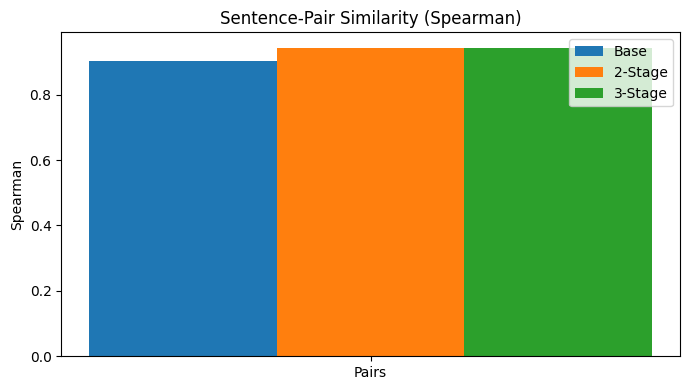

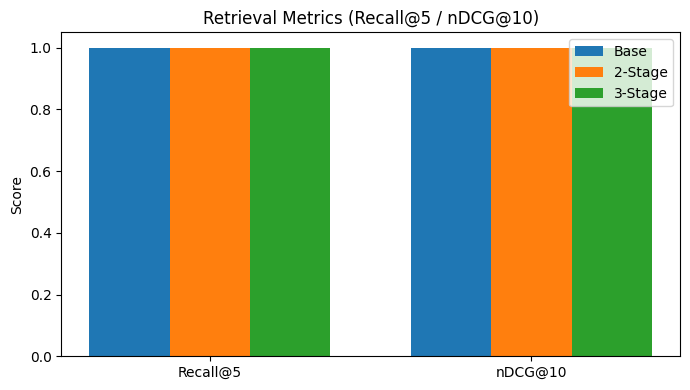

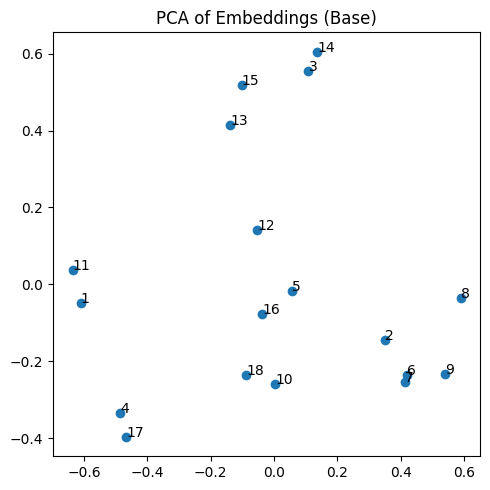

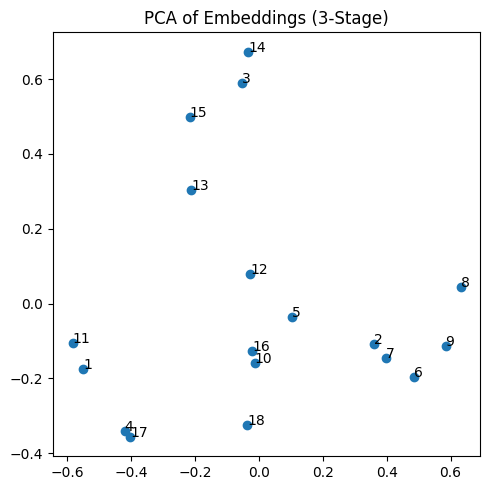

Saved results to: ./outputs_demo


In [9]:
# Final evaluation + plots
base_model   = SentenceTransformer(BASE_MODEL)
 
stage2_model = SentenceTransformer(os.path.join(OUT_DIR, "minilm-medical"))
stage3_model = SentenceTransformer(os.path.join(OUT_DIR, "minilm-medical-3stage"))
base_pair_corr = eval_sentence_pairs("Base", base_model, pairs_rows)
stage2_pair_corr = eval_sentence_pairs("2-Stage", stage2_model, pairs_rows)
stage3_pair_corr = eval_sentence_pairs("3-Stage", stage3_model, pairs_rows)

base_recall, base_ndcg = eval_retrieval("Base", base_model, qa_rows, docs_rows)
stage2_recall, stage2_ndcg = eval_retrieval("2-Stage", stage2_model, qa_rows, docs_rows)
stage3_recall, stage3_ndcg = eval_retrieval("3-Stage", stage3_model, qa_rows, docs_rows)

pairs_plot = os.path.join(OUT_DIR, "pairs_spearman_3way.png")
plot_triple_bars([base_pair_corr], [stage2_pair_corr], [stage3_pair_corr],
                 "Sentence-Pair Similarity (Spearman)", "Spearman", ["Pairs"],
                 ["Base", "2-Stage", "3-Stage"], pairs_plot)

retr_plot = os.path.join(OUT_DIR, "retrieval_metrics_3way.png")
plot_triple_bars([base_recall, base_ndcg], [stage2_recall, stage2_ndcg], [stage3_recall, stage3_ndcg],
                 "Retrieval Metrics (Recall@5 / nDCG@10)", "Score", ["Recall@5", "nDCG@10"],
                 ["Base", "2-Stage", "3-Stage"], retr_plot)

sample_texts = [r["query"] for r in qa_rows[:6]] + [d["text"] for d in docs_rows[:12]]
pca_base_path = os.path.join(OUT_DIR, "pca_base.png")
pca_3stage_path = os.path.join(OUT_DIR, "pca_3stage.png")
plot_pca_scatter("Base", base_model, sample_texts, pca_base_path, "PCA of Embeddings (Base)")
plot_pca_scatter("3-Stage", stage3_model, sample_texts, pca_3stage_path, "PCA of Embeddings (3-Stage)")

summary = {
    "base": {"pairs_spearman": float(base_pair_corr), "recall@5": float(base_recall), "ndcg@10": float(base_ndcg)},
    "stage2": {"pairs_spearman": float(stage2_pair_corr), "recall@5": float(stage2_recall), "ndcg@10": float(stage2_ndcg)},
    "stage3": {"pairs_spearman": float(stage3_pair_corr), "recall@5": float(stage3_recall), "ndcg@10": float(stage3_ndcg)}
}
with open(os.path.join(OUT_DIR, "summary_3way.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("Saved results to:", OUT_DIR)

---

## (Optional) Phase 3 — Triplet fine‑tuning on `(q, pos, neg)`
Adds *hard‑negative discrimination*. You can skip if you only need a quick demo.


In [10]:
# Triplet training (optional)
from sentence_transformers import losses as st_losses

triplets_rows = []
with open(os.path.join(DATA_DIR, "triplets.jsonl"), "r") as f:
    for line in f:
        if line.strip():
            triplets_rows.append(json.loads(line))

if len(triplets_rows) > 0:
    ft2_model = SentenceTransformer(FT_DIR)  # start from phase-2 model
    triplet_examples = [
        InputExample(texts=[r["query"].strip(), r["pos"].strip(), r["neg"].strip()])
        for r in triplets_rows
    ]
    loader_tri = DataLoader(triplet_examples, shuffle=True, batch_size=min(8, len(triplet_examples)), drop_last=False)
    loss_tri = st_losses.TripletLoss(
        model=ft2_model,
        distance_metric=st_losses.TripletDistanceMetric.COSINE
    )


    ft2_model.fit(
        train_objectives=[(loader_tri, loss_tri)],
        epochs=2,
        warmup_steps=0,
        optimizer_params={'lr': 1e-5},
        use_amp=torch.cuda.is_available(),
        show_progress_bar=True
    )

    FT2_DIR = os.path.join(OUT_DIR, "minilm-medical-triplet")
    os.makedirs(FT2_DIR, exist_ok=True)
    ft2_model.save(FT2_DIR)
    print("Triplet phase done. Saved to:", FT2_DIR)
else:
    print("No triplets found; skipping Triplet phase.")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


Triplet phase done. Saved to: ./outputs_demo/minilm-medical-triplet


[Base] Sentence-pair Spearman: 0.9038
[Fine-tuned] Sentence-pair Spearman: 0.9431
[FT+Triplet] Sentence-pair Spearman: 0.9431
[Base] Retrieval Recall@5: 1.000, nDCG@10: 1.000
[Fine-tuned] Retrieval Recall@5: 1.000, nDCG@10: 1.000
[FT+Triplet] Retrieval Recall@5: 1.000, nDCG@10: 1.000


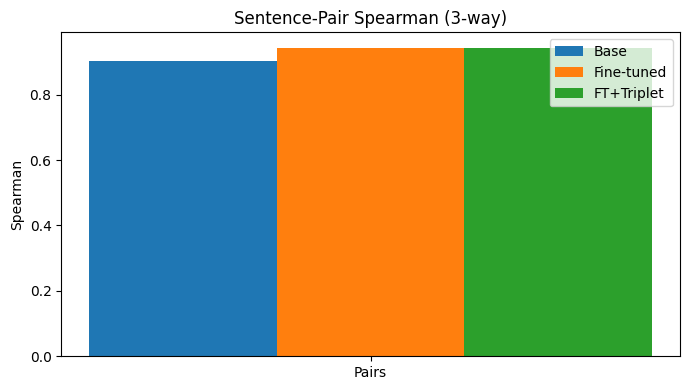

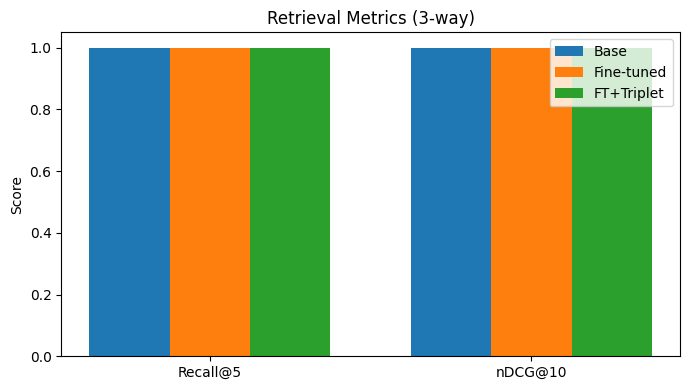

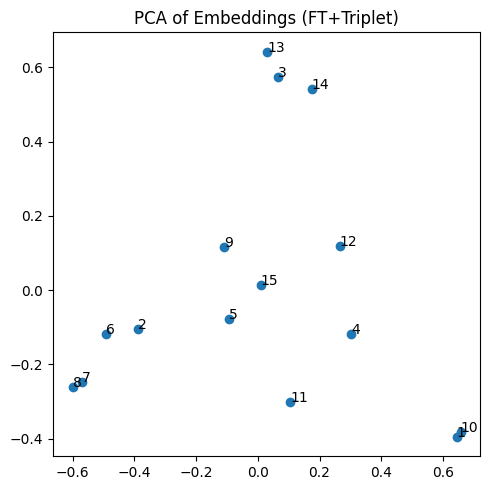

Saved three-way summary to: ./outputs_demo/summary_three_way.json


In [11]:
# Three-way comparison if Triplet model exists
FT2_DIR = os.path.join(OUT_DIR, "minilm-medical-triplet")
if os.path.isdir(FT2_DIR) and len(os.listdir(FT2_DIR)) > 0:
    base_model = SentenceTransformer(BASE_MODEL)
    ft_model   = SentenceTransformer(FT_DIR)
    ft2_model  = SentenceTransformer(FT2_DIR)

    # sentence pairs
    base_pairs = eval_sentence_pairs("Base", base_model, pairs_rows)
    ft_pairs   = eval_sentence_pairs("Fine-tuned", ft_model, pairs_rows)
    ft2_pairs  = eval_sentence_pairs("FT+Triplet", ft2_model, pairs_rows)

    # retrieval
    base_recall, base_ndcg = eval_retrieval("Base", base_model, qa_rows, docs_rows)
    ft_recall,   ft_ndcg   = eval_retrieval("Fine-tuned", ft_model, qa_rows, docs_rows)
    ft2_recall,  ft2_ndcg  = eval_retrieval("FT+Triplet", ft2_model, qa_rows, docs_rows)

    # plots
    plot_triple_bars(
        [base_pairs],
        [ft_pairs],
        [ft2_pairs],
        "Sentence-Pair Spearman (3-way)",
        "Spearman",
        ["Pairs"],
        ["Base", "Fine-tuned", "FT+Triplet"],  # ✅ legend_labels
        os.path.join(OUT_DIR, "pairs_spearman_three_way.png")
    )

    plot_triple_bars(
        [base_recall, base_ndcg],
        [ft_recall, ft_ndcg],
        [ft2_recall, ft2_ndcg],
        "Retrieval Metrics (3-way)",
        "Score",
        ["Recall@5", "nDCG@10"],
        ["Base", "Fine-tuned", "FT+Triplet"],  # ✅ legend_labels
        os.path.join(OUT_DIR, "retrieval_metrics_three_way.png")
    )

    # PCA (optional): show FT+Triplet as well
    sample_texts = [r["query"] for r in qa_rows[:5]] + [d["text"] for d in docs_rows[:10]]
    plot_pca_scatter("FT+Triplet", ft2_model, sample_texts,
                     os.path.join(OUT_DIR, "pca_ft_triplet.png"),
                     "PCA of Embeddings (FT+Triplet)")

    summary3 = {
        "base": {"pairs_spearman": float(base_pairs), "recall@5": float(base_recall), "ndcg@10": float(base_ndcg)},
        "finetuned": {"pairs_spearman": float(ft_pairs), "recall@5": float(ft_recall), "ndcg@10": float(ft_ndcg)},
        "ft_triplet": {"pairs_spearman": float(ft2_pairs), "recall@5": float(ft2_recall), "ndcg@10": float(ft2_ndcg)},
    }
    with open(os.path.join(OUT_DIR, "summary_three_way.json"), "w") as f:
        json.dump(summary3, f, indent=2)
    print("Saved three-way summary to:", os.path.join(OUT_DIR, "summary_three_way.json"))
else:
    print("Triplet model not found; skip 3-way comparison.")

---

### ✅ What to expect
- **Sentence-Pair Spearman** should increase after fine‑tuning.
- **Retrieval Recall@5 / nDCG@10** should also go up.
- **PCA** plots will show tighter clusters / better query‑passage alignment.

> To amplify improvements, you can increase EPOCHS or add more QA pairs.

**Blog assets**: Figures & JSON summaries are saved under `./outputs_demo/`.
